In [97]:
%load_ext autoreload
%autoreload 2

from copy import deepcopy
import os
import time
import pydrake
from pydrake.all import (
    CommonSolverOption,
    MathematicalProgram,
    MakeSolver,
    GurobiSolver,
    Solve,
    SolverOptions,
    VPolytope
)
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy as sp
from geometric_only_grammar import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Minimal grammar definition: each node has:
- a pose x
- a type name

A node class defines:
- its child type (by name or None)
- max # of children
- the geometric stop prob p (1. = always 1 child, 0. = infinite children)
- the region in which children will be produced (uniformly at random), in the frame of the node, in the form of an axis-aligned bounding box

E.g. object groups in plane:
- Root node produces object clusters and uniform random locations inside [0, 1]^2.
- Each cluster produces up points uniformly in a 0.1-length box centered at the cluster center.

Text(0.5, 1.0, 'Observed nodes')

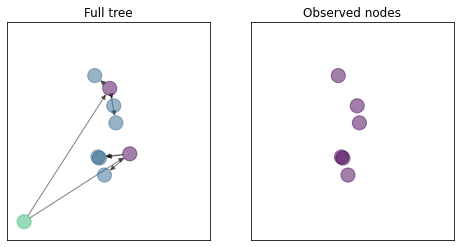

In [98]:
# Grammar implementing clusters of points in 2D.
cluster_grammar = {
    "point": NodeDefinition(child_type=None, p=None, max_children=None, bounds=None),
    #"cluster_cluster": NodeDefinition(child_type="cluster", p=0.5, max_children=3, bounds=[-np.ones(2)*0.2, np.ones(2)*0.22]),
    "cluster": NodeDefinition(child_type="point", p=0.25, max_children=3, bounds=[-np.ones(2)*0.2, np.ones(2)*0.2]),
    "root": NodeDefinition(child_type="cluster", p=0.5, max_children=3, bounds=[np.ones(2)*0.2, np.ones(2)*0.8])
}
cluster_grammar_observed_types = ["point"]

np.random.seed(3)
example_tree = sample_tree(cluster_grammar)
observed_nodes = deepcopy(get_observed_nodes(example_tree, cluster_grammar_observed_types))

plt.figure().set_size_inches(8, 4)
plt.subplot(1, 2, 1)
draw_tree(example_tree)
plt.title("Full tree")
plt.subplot(1, 2, 2)
draw_observed_nodes(observed_nodes)
plt.title("Observed nodes")

# MIP for 

We want to do "scene parsing:" given an observed scene $obs$ + a grammar description, find the maximum-a-posteriori tree $T$ that maximizes

$$ p(T | obs) = \dfrac{p(obs | T) p(T)}{p(obs)} $$

$p(obs | T)$ is an indicator function that is 1 iff $T$ can produce $obs$. $p(T)$ is the product of the discrete node production choices (each one a draw of child count from a geometric distribution) and the continuous choices (each one a draw of child position from a uniform distribution).

We ignore the marginal dist $p(obs)$ since it doesn't depend on $T$.

**Mixed integer parsing strategy**:
- Given the grammar description and a list of observed nodes, find the maximum likelihood parse tree from that grammar that explains that scene.
- Build the "super tree" of node types in the grammar: the scene tree (of types) that would result if every possible child node was produced.
- Add a binary variable to each node in the super tree, indicating whether that node is active in the parse of the given scene.
  - (Constraint: a node can't be active if its direct parent isn't active.)
- Add a 2D continuous variable to each node in the super tree to decide where that node is, if it's active in the parse of the scene.
  - (Constraint: a child must be in a legal position relative to the parent, i.e. within axis-aligned bounds of the parent position as a linear constraint.)
- Add an edge from every observed node to every node in the super tree that could have produced it, with a binary variable per edge indicating which super-tree node is explaining which observed node.
  - (Constraint: each observed node is explained by exactly one node in the tree.)
  - (Constraint: each observed "type" in the super tree is active only if it's explaining an observed node, and explains at most one observed node.)
  - (Constraint: if a super tree node is explaining an observed node, its position is constrained to be equal to the observed node position.)

Text(0.5, 1.0, 'Super tree for cluster grammar')

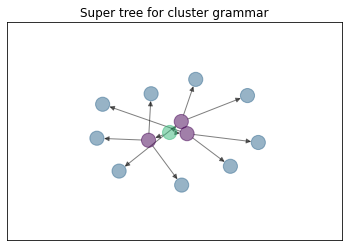

In [99]:
def make_super_tree(grammar):
    # Same logic as sampling a tree, but instead takes *all*
    # choices (but doesn't bother with sampling x).
    tree = nx.DiGraph()
    root = Node("root", x=np.array([0., 0.]))
    tree.add_node(root)
    node_queue = [root]
    
    while len(node_queue) > 0:
        parent = node_queue.pop(0)
        assert parent.type in grammar.keys()
        parent_def = grammar[parent.type]
        if parent_def.child_type is None:
            continue
        n_children = parent_def.max_children

        for k in range(n_children):
            child = Node(parent_def.child_type, np.zeros(2))
            tree.add_node(child)
            tree.add_edge(parent, child)
            node_queue.append(child)
    return tree
super_tree = make_super_tree(cluster_grammar)
draw_tree(super_tree, draw_pos=False)
plt.xlim([-2., 2.])
plt.ylim([-2., 2.])
plt.title("Super tree for cluster grammar")

In [178]:
# Make a super tree and observed node set, which we'll modify to organize our optimization variables.

def infer_mle_tree(grammar, observed_nodes, observed_node_types, verbose=False, optimize_positions=True,
                   discrete_symmetry_breaking=True, continuous_symmetry_breaking=True):
    super_tree = make_super_tree(grammar)
    observed_nodes = deepcopy(observed_nodes)

    prog = MathematicalProgram()

    # Every node gets a binary variable to indicate
    # whether it's active or node. This is equivalent to a
    # binary variable on the incoming edge for the node.
    active_vars = prog.NewBinaryVariables(len(super_tree.nodes), "nodes_active")
    for k, node in enumerate(super_tree.nodes):
        node.active = active_vars[k]

    # Every node gets a position, which is continuous inside the 2D unit box.
    if optimize_positions:
        for k, node in enumerate(super_tree.nodes):
            node.x_optim = prog.NewContinuousVariables(2, "%s_%d_x" % (node.type, k))
            prog.AddBoundingBoxConstraint(-1., 2., node.x_optim)
            if node.type == "root":
                # Fix root since we know it should be at origin
                prog.AddBoundingBoxConstraint(0., 0., node.x_optim)


    # For each node in the super tree, add relationships between the parent
    # and that node.
    for parent_node in super_tree:
        children = list(super_tree.successors(parent_node))
        child_actives = [c.active for c in children]
        child_xys = [c.x_optim for c in children]
        parent_node.child_actives = child_actives

        # Children active requires parent active.
        for child_active in child_actives:
            prog.AddLinearConstraint(parent_node.active >= child_active)

        # Geometric node child ordering to reduce duplicate parse: a child can
        # only be active if the previous child is also active.
        # Also make the children appear in ascending x order. (The x's are
        # continuous, so this will generally provide a unique ordering without
        # too much math overhead.)
        for k in range(len(child_actives) - 1):
            # child_{k+1} implies child_k
            # i.e. child_k >= child_{k+1}
            if discrete_symmetry_breaking:
                prog.AddLinearConstraint(child_actives[k] >= child_actives[k+1])

            # child_{k+1} is at same x position or greater than child_{k}
            if continuous_symmetry_breaking:
                prog.AddLinearConstraint(child_xys[k+1][0] >= child_xys[k][0])

        # Add negative log prob cost for geometric activation: each additional
        # node activation incurs a penalty based on the geometric stopping probability.
        # (I'm discarding the probability that we terminated, since we assume that we
        # always terminated. TODO: I'm not sure if that's true, since we truncate at some
        # max # of groups.)
        #termination_nll = -np.log(p)
        p = grammar[parent_node.type].p
        for k in range(len(child_actives)):
            prog.AddLinearCost(child_actives[k] * -np.log(1. - p))
        # The geometric process we used (np.random.geometric) is only supported
        # on k=1, ..., so constrain that the # of active children must be
        # nonzero if this node is on.
        if len(child_actives) > 0:
            prog.AddLinearConstraint(sum(child_actives) >= parent_node.active)

        if optimize_positions and len(children) > 0:
            # The children are uniformly distributed inside a box relative
            # to the parent, so the log prob of this node's position is
            # just 1 / area. For model comparison reasons, we need to consider
            # all nodes (even non-active ones), I think?
            lb, ub = grammar[parent_node.type].bounds
            nll = -np.log(1. / np.prod(ub - lb))
            for child in children:
                prog.AddLinearCost(nll)

            # However, the child needs to be constrained to be within
            # the specified bounds of the parent position if the child
            # is active.
            for child in children:
                # I want this to work:
                # S = VPolytope.MakeBox(lb, ub)
                # S.AddPointInSetConstraints(prog, parent_node.x_optim - child.x_optim)
                # but it's not happy. What gives?
                for i in range(2):
                    prog.AddLinearConstraint(child.x_optim[i] >= parent_node.x_optim[i] + lb[i])
                    prog.AddLinearConstraint(child.x_optim[i] <= parent_node.x_optim[i] + ub[i])


    # For each observed node, add a binary variable for each possible
    # correspondence to a node in the observed set, where an active correspondence
    # forces the corresponded node to be the same position as the observed node.
    for n in super_tree:
        # (first prep some bookkeeping)
        n.outgoings = []
    for observed_node in observed_nodes:
        possible_sources = [n for n in super_tree if n.type == observed_node.type]
        source_actives = prog.NewBinaryVariables(len(possible_sources), observed_node.type + "_sources")

        # Store these variables
        observed_node.source_actives = source_actives
        for k, n in enumerate(possible_sources):
            n.outgoings.append(source_actives[k])

        # Each observed node needs exactly one explaining input.
        prog.AddLinearEqualityConstraint(sum(source_actives) == 1)
        
        if optimize_positions:
            for k, node in enumerate(possible_sources):
                M = 1. # Should upper bound positional error in any single dimension
                # When correspondence is active, force the node to match the observed node.
                # Otherwise, it can vary within a big M of the observed node.
                for i in range(2):
                    prog.AddLinearConstraint(node.x_optim[i] <= observed_node.x[i] + 1E-6 + (1. - source_actives[k]) * M)
                    prog.AddLinearConstraint(node.x_optim[i] >= observed_node.x[i] - 1E-6 - (1. - source_actives[k]) * M)

    # Go back and make sure no node in the super tree is being used
    # to explain more than one observed node, and that the "observed"
    # nodes are only active if they are explaining something.
    # TODO(gizatt) These constraints are a little frustrating: without
    # them, the parsing likes to hallucinate unnecessary hidden nodes
    # since adding them increases the tree likelihood (since the net log-prob
    # of adding a new node is positive due to concentrated densities).
    # It makes me feel like I'm doing something fundamentally wrong, like using
    # total model prob to do model comparisons between models of different size.
    for node in super_tree:
        if node.type in observed_node_types:
            if len(node.outgoings) > 0:
                prog.AddLinearConstraint(sum(node.outgoings) <= 1)
                prog.AddLinearConstraint(node.active == sum(node.outgoings))
            else:
                # Never observed this type, so this node can't be active.
                prog.AddLinearConstraint(node.active == 0)
            
    solver = GurobiSolver()
    options = SolverOptions()
    logfile = "/tmp/gurobi.log"
    os.system("rm %s" % logfile)
    options.SetOption(solver.id(), "LogFile", logfile)
    if verbose:
        print("Num vars: ", prog.num_vars())
        print("Num constraints: ", sum([c.evaluator().num_constraints() for c in prog.GetAllConstraints()]))
    result = solver.Solve(prog, None, options)
    if verbose:
        print("Optimization success?: ", result.is_success())
        print("Logfile: ")
        with open(logfile) as f:
            print(f.read())
    TreeInferenceResults = namedtuple("TreeInferenceResults", ["optim_result", "super_tree", "observed_nodes"])
    return TreeInferenceResults(result, super_tree, observed_nodes)
    

observed_nodes = deepcopy(get_observed_nodes(example_tree, cluster_grammar_observed_types))
start_time = time.time()
inference_results = infer_mle_tree(
    cluster_grammar, observed_nodes, cluster_grammar_observed_types,
    verbose=True, optimize_positions=True
)
elapsed = time.time() - start_time
print("Took %f secs" % elapsed)

Num vars:  25
Num constraints:  80
Optimization success?:  True
Logfile: 

Gurobi 9.0.2 (linux64) logging started Thu Jul 29 18:24:31 2021


Took 0.045959 secs


In [179]:
# Symmetry breaking time experiment
N_trials = 10

cases = {}
with_sym_break = []
without_sym_break = []
for discrete_symmetry_breaking in [True, False]:
    for continuous_symmetry_breaking in [True, False]:
        cases[(discrete_symmetry_breaking, continuous_symmetry_breaking)] = []
        for k in range(N_trials):
            start_time = time.time()
            inference_results = infer_mle_tree(
                cluster_grammar, observed_nodes, cluster_grammar_observed_types,
                verbose=False, optimize_positions=True,
                discrete_symmetry_breaking=discrete_symmetry_breaking,
                continuous_symmetry_breaking=continuous_symmetry_breaking
            )
            elapsed = time.time() - start_time            
            cases[(discrete_symmetry_breaking, continuous_symmetry_breaking)].append(elapsed)
        data =cases[(discrete_symmetry_breaking, continuous_symmetry_breaking)]
        print("Discrete breaking (%d), continuous breaking (%d): %0.03f +/- %0.03f" % (
            discrete_symmetry_breaking, continuous_symmetry_breaking,
            np.mean(data), np.std(data)
        ))

Discrete breaking (1), continuous breaking (1): 0.028 +/- 0.006
Discrete breaking (1), continuous breaking (0): 0.029 +/- 0.001
Discrete breaking (0), continuous breaking (1): 0.029 +/- 0.002
Discrete breaking (0), continuous breaking (0): 0.027 +/- 0.002


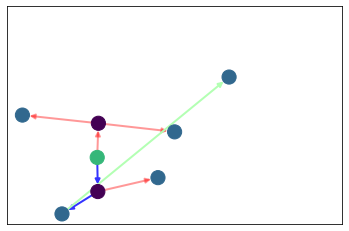

In [180]:
# Draws the super-tree to the left
def draw_mle_tree_corrs(inference_results):
    super_tree = inference_results.super_tree
    observed_nodes = inference_results.observed_nodes
    result = inference_results.optim_result

    drawing_tree = super_tree.copy()
    for observed_node in observed_nodes:
        drawing_tree.add_node(observed_node)
        possible_sources = [n for n in super_tree if n.type == observed_node.type]
        if not np.isclose(np.sum(result.GetSolution(observed_node.source_actives)), 1.):
            print("WARN: observed node not explained by MLE sol.")
        for k, s in enumerate(possible_sources):
            if result.GetSolution(observed_node.source_actives[k]):
                drawing_tree.add_edge(s, observed_node)

    pos = nx.spring_layout(super_tree)
    # Shift super tree drawing entirely to the negative unit box
    ur = np.max(np.array(list(pos.values())), axis=0)
    ll = np.min(np.array(list(pos.values())), axis=0)
    for k, x in pos.items():
        pos[k] = (x - ll)/(ur - ll) - 1.
    # Add in positions for observed nodes, which should be in positive unit box.
    for n in observed_nodes:
        pos[n] = n.x

    edge_colors = []
    for parent, child in drawing_tree.edges:
        if hasattr(child, "active"):
            # Child is in supertree
            active = result.GetSolution(child.active)
            if active:
                assert result.GetSolution(parent.active)
                edge_colors.append([0.2, 0.2, 1., 1.])
            else:
                edge_colors.append([1.0, 0.2, 0.2, 0.5])
        else:
            # When we built drawing tree, we only added the
            # active + explaining node for each observed node.
            assert result.GetSolution(parent.active)
            edge_colors.append([0.7, 1.0, 0.7, 1.0])
    unique_types = sorted(list(set([n.type for n in drawing_tree])))
    n_types = len(unique_types)
    cm = plt.get_cmap("viridis")
    color_mapping = {unique_type: cm(float(k)/n_types) for k, unique_type in enumerate(unique_types)}
    nx.draw_networkx(
        drawing_tree,
        with_labels=False,
        pos=pos,
        node_color=[color_mapping[node.type] for node in drawing_tree],
        edge_color=edge_colors,
        width=2,
        node_size=200,
    )
    plt.gca().set_xlim([-1.1, 1.1])
    plt.gca().set_ylim([-1.1, 1.1])
draw_mle_tree_corrs(inference_results)

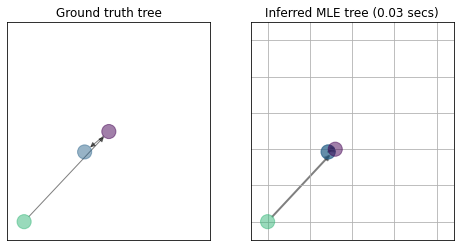

In [181]:
# Draws the optimized tree in the optimized positions.
# Draws the super-tree to the left
def draw_mle_tree(inference_results):
    super_tree = inference_results.super_tree
    observed_nodes = inference_results.observed_nodes
    result = inference_results.optim_result

    drawing_tree = nx.DiGraph()

    for observed_node in observed_nodes:
        copy_node = deepcopy(observed_node)
        copy_node.type = observed_node.type
        drawing_tree.add_node(copy_node)
        possible_sources = [n for n in super_tree if n.type == observed_node.type]
        if not np.isclose(np.sum(result.GetSolution(observed_node.source_actives)), 1.):
            print("WARN: observed node at %s not explained by MLE sol." % observed_node.x)
        for k, s in enumerate(possible_sources):
            if result.GetSolution(observed_node.source_actives[k]):
                drawing_tree.add_node(s)
                drawing_tree.add_edge(s, copy_node)

    for node in super_tree:
        if result.GetSolution(node.active):
            drawing_tree.add_node(node)
            parents = list(super_tree.predecessors(node))
            assert len(parents) <= 1
            if len(parents) == 1:
                parent = parents[0]
                assert result.GetSolution(parent.active)
                drawing_tree.add_edge(parent, node)

    pos = {}
    for n in drawing_tree:
        if hasattr(n, "active"):
            pos[n] = result.GetSolution(n.x_optim)
        else:
            pos[n] = n.x


    unique_types = sorted(list(set([n.type for n in drawing_tree])))
    n_types = len(unique_types)
    cm = plt.get_cmap("viridis")
    color_mapping = {unique_type: cm(float(k)/n_types) for k, unique_type in enumerate(unique_types)}
    nx.draw_networkx(
        drawing_tree,
        with_labels=False,
        pos=pos,
        alpha=0.5,
        node_color=[color_mapping[node.type] for node in drawing_tree],
        width=2,
        node_size=200,
        #node_size = [unique_types.index(node.type)*100 for node in drawing_tree]
    )
    plt.gca().set_xlim([-0.1, 1.1])
    plt.gca().set_ylim([-0.1, 1.1])


plt.figure().set_size_inches(8, 4)
plt.subplot(1, 2, 1)
draw_tree(example_tree)
plt.title("Ground truth tree")
plt.subplot(1, 2, 2)
draw_mle_tree(inference_results)
plt.title("Inferred MLE tree (%0.02f secs)" % elapsed)
plt.grid(True)

Num vars:  37
Num constraints:  131
Optimization success?:  True
Logfile: 

Gurobi 9.0.2 (linux64) logging started Thu Jul 29 18:14:16 2021


0: Inferred for 4 node scene in 0.054138 secs
Num vars:  29
Num constraints:  97
Optimization success?:  True
Logfile: 

Gurobi 9.0.2 (linux64) logging started Thu Jul 29 18:14:17 2021


1: Inferred for 2 node scene in 0.026257 secs
Num vars:  29
Num constraints:  97
Optimization success?:  True
Logfile: 

Gurobi 9.0.2 (linux64) logging started Thu Jul 29 18:14:17 2021


2: Inferred for 2 node scene in 0.025830 secs
Num vars:  33
Num constraints:  114
Optimization success?:  True
Logfile: 

Gurobi 9.0.2 (linux64) logging started Thu Jul 29 18:14:17 2021


3: Inferred for 3 node scene in 0.028360 secs
Num vars:  33
Num constraints:  114
Optimization success?:  True
Logfile: 

Gurobi 9.0.2 (linux64) logging started Thu Jul 29 18:14:17 2021


4: Inferred for 3 node scene in 0.037233 secs
Num vars:  29
Num constraints:  97
Optimization success?:  Tru

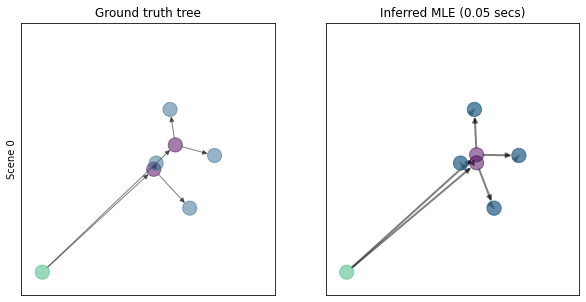

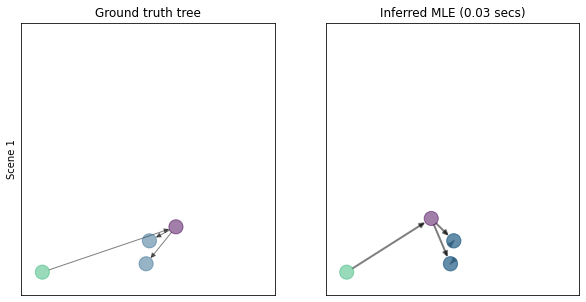

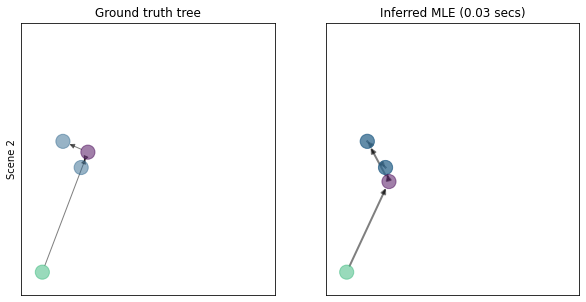

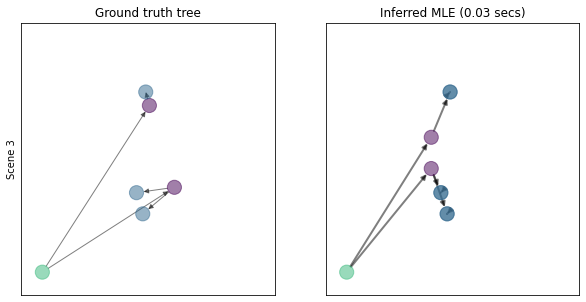

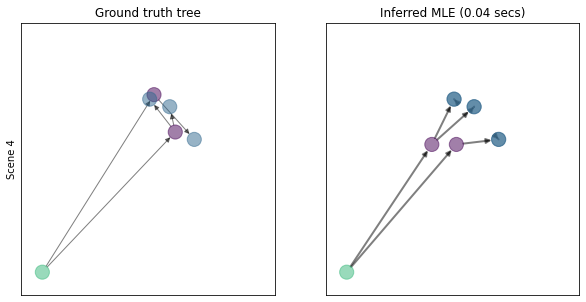

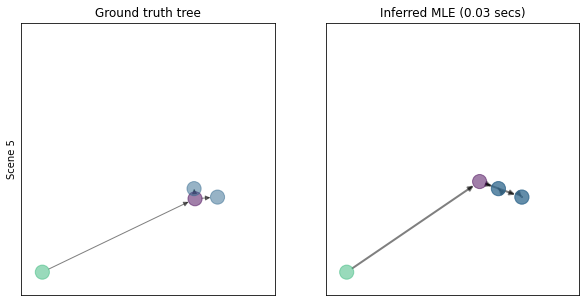

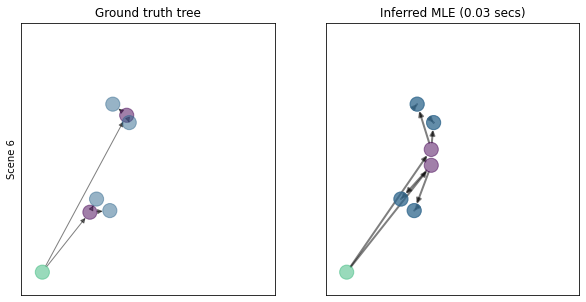

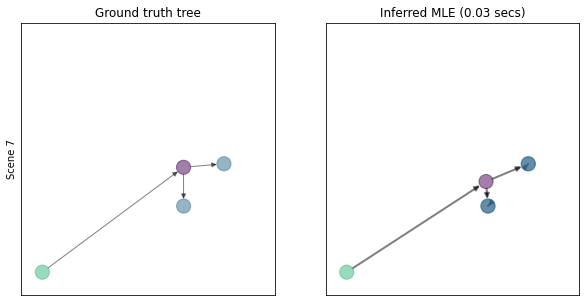

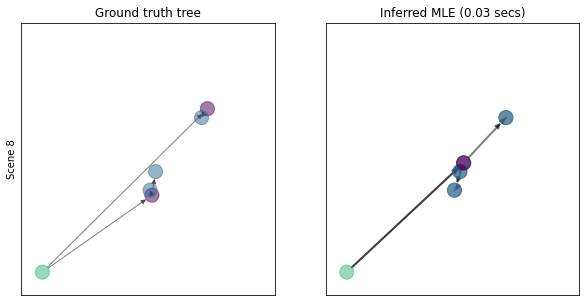

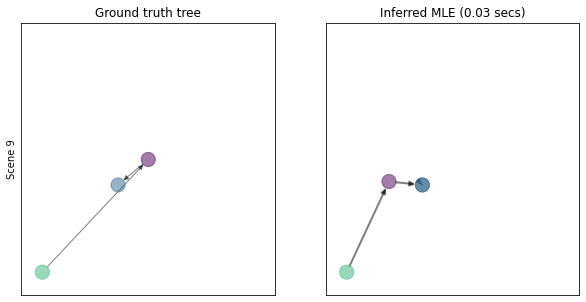

In [177]:
# Generate + infer on a bunch of trees.
N = 10
for k in range(N):
    plt.figure().set_size_inches(10, 5)
    np.random.seed(k)
    plt.subplot(1, 2, 1)
    example_tree = sample_tree(cluster_grammar)
    observed_nodes = deepcopy(get_observed_nodes(example_tree, cluster_grammar_observed_types))
    draw_tree(example_tree)
    plt.title("Ground truth tree")
    plt.ylabel("Scene %d" % k)
    start_time = time.time()
    inference_results = infer_mle_tree(cluster_grammar, observed_nodes, cluster_grammar_observed_types, verbose=True)
    elapsed = time.time() - start_time
    print("%d: Inferred for %d node scene in %f secs" % (k, len(observed_nodes), elapsed))
    if not inference_results.optim_result.is_success():
        print("WARN: Failed optimization.")
        continue
    
    #plt.subplot(1, 3, 3)
    #draw_mle_tree_corrs(inference_results)
    
    plt.subplot(1, 2, 2)
    draw_mle_tree(inference_results)
    plt.title("Inferred MLE (%0.02f secs)" % elapsed)


# Posterior estimation on the super tree by brute-forcing observation correspondences

Now look at the full Bayesian form of scene parsing: given an observed scene $obs$ + a grammar description, find parameters for a representation of the posterior over parse trees $T$ for a given scene $obs$ that maximizes the (log) evidence:

$$
\begin{align}
\max \log p(obs) &= \log \left[ \sum_T p(obs, T) \right] &= \log \left[ \sum_T p(obs | T)p(T) \right]\\
&&\geq \sum_{T \, | \, \text{p(obs | T) = 1}} \log p(T)
\end{align}$$

(Here, drop zero-probability terms from the sum and then apply Jensen's inequality. (In this situation, $p(obs | T)$ is still either 0 or 1, if the tree does or does node induce $obs$.))

So if we can enumerate over feasible parse trees, maybe we could evaluate this brute-force. Parse tree feasibility dictated by:
1) The set of observed nodes have precise explanations in the tree.
2) The tree itself is legal.

I think (1) may be a serious driver of tree diversity. So how about we *explicitly enumerate over observed node correspondences into the super tree*: for each fixed correspondence, optimize a simple approximation of $p(T | correspondences)$. I need new notation for this!

Text(0.5, 1.0, 'Observed nodes')

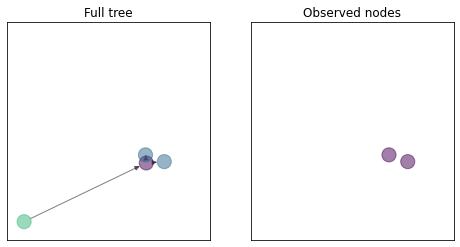

In [137]:
# Grammar implementing clusters of points in 2D.
cluster_grammar = {
    "point": NodeDefinition(child_type=None, p=None, max_children=None, bounds=None),
    #"cluster_cluster": NodeDefinition(child_type="cluster", p=0.5, max_children=3, bounds=[-np.ones(2)*0.2, np.ones(2)*0.22]),
    "cluster": NodeDefinition(child_type="point", p=0.25, max_children=2, bounds=[-np.ones(2)*0.2, np.ones(2)*0.2]),
    "root": NodeDefinition(child_type="cluster", p=0.5, max_children=2, bounds=[np.ones(2)*0.2, np.ones(2)*0.8])
}
cluster_grammar_observed_types = ["point"]

np.random.seed(5)
example_tree = sample_tree(cluster_grammar)
observed_nodes = deepcopy(get_observed_nodes(example_tree, cluster_grammar_observed_types))

plt.figure().set_size_inches(8, 4)
plt.subplot(1, 2, 1)
draw_tree(example_tree)
plt.title("Full tree")
plt.subplot(1, 2, 2)
draw_observed_nodes(observed_nodes)
plt.title("Observed nodes")

In [138]:
# Make a super tree and observed node set, which we'll modify to organize our optimization variables.

def infer_tree_dist_by_corr_enum(grammar, observed_nodes, observed_node_types, verbose=False):
    clean_super_tree = make_super_tree(grammar)
    observed_nodes = deepcopy(observed_nodes)

    prog = MathematicalProgram()

    # Build the master list of super-tree-to-observed-node correspondences in the form
    # of supertree copies with "active" and "xy" entries of all observed_node_type
    # nodes set.
    # Algorithm: step through observed nodes in order. For the i^th observed node's
    # non-occupied same-type choices in the super tree, select the k^th, where k =
    # choice_inds[i].
    # When all are correspondended, we're done; increment choice inds, starting from
    # the right; an entry rolls over to zero and the entry to the left is incremented
    # if the entry goes above the number of choices that would be available at that
    # index.
    explaining_node_sets = {
        obs_type: [node for node in super_tree.nodes if node.type == obs_type]
        for obs_type in observed_node_types
    }
    choice_inds = np.zeros(len(observed_nodes))
    # Calculate # of choices we expect to have at each step in matching.
    choice_n_choices = []
    n_choices_by_type = {obs_type: 0 for obs_type in observed_node_types}
    for observed_node in observed_nodes:
        obs_type = observed_node.type
        n_choices = len(explaining_node_sets[obs_type]) - n_choices_by_type[obs_type]
        n_choices_by_type[obs_type] += 1
        choice_n_choices.append(n_choices)
    print(choice_n_choices)
    iters = 0
    while True:        
        # Increment choice inds and check if we're ready to terminate.
        terminate = False
        choice_inds[-1] += 1
        # Do carries.
        for i in range(len(choice_inds)-1, -1, -1):
            if choice_inds[i] >= choice_n_choices[i]:
                choice_inds[i] = 0
                if i == 0:
                    # Carried the first choice ind; we're done with all permutations.
                    terminate = True
                    break
                else:
                    choice_inds[i-1] += 1
        iters += 1
        if terminate:
            break
    print("Iters: ", iters)

observed_nodes = deepcopy(get_observed_nodes(example_tree, cluster_grammar_observed_types))
print("Starting with %d observed nodes" % len(observed_nodes))
start_time = time.time()
inference_results = infer_tree_dist_by_corr_enum(
    cluster_grammar, observed_nodes, cluster_grammar_observed_types,
    verbose=True
)
elapsed = time.time() - start_time
print("Took %f secs" % elapsed)

Starting with 2 observed nodes
[9, 8]
Iters:  72
Took 0.004964 secs


# Posterior estimation on the super tree using full enumeration of trees

Now look at the full Bayesian form of scene parsing: given an observed scene $obs$ + a grammar description, find a representation of the posterior over parse trees $T$ for a given scene $obs$ that maximizes the (log) evidence:

$$ \log p(obs) = \log \left[ \sum_T p(obs | T) p(T)\right] $$

Now we need to worry about distributions over *whole trees*. Using the super-tree idea, we can describe any given tree as a binary vector $B = [b_1, ..., b_N]$ and continuous vector $C = [xy_1, ..., xy_N]$, concatenating the activation and xy variables for the $N$ nodes in the super tree. Distributions over trees are distributions over the joint space $p(B, C)$.

That space is nasty to represent, but we can try approximations -- here's a pretty exhaustive but expressive one:
1) For every distinct tree in the $2^N$ options (i.e. for each binary vector $B$), create decision variables as the parameters for a distribution over $C$. (i.e., fit a distribution for C for every distinct possible tree.)
2) Create $2^N$ continuous decision variables for the Categorical weights for a given tree / binary vector $B$ being chosen.

What distribution we use for $C$ probably depends on the grammar; maybe I can relate it to the variational approximation in VI.

The optimization becomes optimizing those parameters w.r.t.
$$
\begin{align}
\max \log p(obs) &= \log \left[ \sum_T p(obs | T) p(T) \right] \\
&\geq \sum_{T \, | \, p(obs | T) = 1 \, and \, p(T) > 0} \log p(T)
\end{align}$$

by dropping zero-probability terms from the sum and then applying Jensen's inequality. (In this situation, $p(obs | T)$ is still either 0 or 1, if the tree does or does node induce $obs$.)

Evaluation of $\log p(T)$ should be doable; the topology is fixed from the value for $B$, but the exact form of the parameter space for $C$ will decide how this is done.

Evaluation of $p(obs | T) = 1$ is a feasibility check: can the current tree produce the observation set? Importantly, this is a set-to-set evaluation: for each observed node, is the distance to the closest active node zero? (This requires a set of binary correspondence variables for each $T$...)
    
(I think that's going to create and explosion of variables, but we can try it.)

TODO(gizatt) IMPLEMENTATION BELOW IS TRASHY ABOUT COST: MIXES REGULAR PROB, LOG PROB, ETc.

KL divergence derivation:
Split $T$ into its discrete latent structure $B$; its continuous latent node positions $X$; and the latent-to-observed correspondences $C$.

Find $q(T)$ close to $p(T | o)$. Roughly following (6.1) in Ritchie's PhD thesis (but with a different setup) -- importantly, keeping the KL divergence ordering the same:
$$
\begin{align}
\min_\theta D_{KL}&(p(T | o) || q(T) \\
=& min_\theta \sum_{T} P(T | o) \log \dfrac{p(T | o)}{q(T)} \\ 
=& min_\theta \sum_{T \, s.t. \, P(T | o) > 0} P(T | o) \log p(T | o) - P(T | o) \log q_\theta(T) \\
=& max_\theta \sum_{T \, s.t. \, P(T | o) > 0} P(T | o) \log q_\theta(T) \\
=& max_\theta \sum_{\text{feasible } B} P(B) * \left[ \sum_{\text{feasible } X, C} P(X, C | o, B) \log q_{\theta}(B, X, C) \right]
\end{align}
$$
$q\theta(T)$ is parameterized by a set of weights $\theta^w$ over the feasible $B$, plus separate parameter sets $\theta^{XC}_i$ for variational posteriors over $X$ and $C$ for each feasible $B$.

In this strategy, we're taking the outer sum explicitly; but to estimate $P(X, C | o, B) \log q_\theta(B, X, C)$, we assume that posterior is concentrated at one optimal $X, C$ for each $o, B$, which we find and optimize jointly with $\theta$ in a MIP that looks like our oneshot parsing problem.

In [151]:
# Make a super tree and observed node set, which we'll modify to organize our optimization variables.
def infer_tree_dist_by_tree_enum(grammar, base_observed_nodes, observed_node_types, verbose=False):
    setup_start_time = time.time()
    base_super_tree = make_super_tree(grammar)
    base_observed_nodes = deepcopy(base_observed_nodes)

    prog = MathematicalProgram()

    # Assumption here that super_tree.nodes is consistently ordered before;after deepcopy.
    # Testing real quick...
    copied_nodes = deepcopy(base_super_tree).nodes
    assert([n1.type == n2.type and np.allclose(n1.x, n2.x)
            for n1, n2 in zip(base_super_tree.nodes, deepcopy(base_super_tree).nodes)])
    
    # Give nodes consistent and easy-to-get indices.
    for k, node in enumerate(base_super_tree.nodes):
        node.ind = k
    n_nodes = len(base_super_tree.nodes)
    n_combinations = 2**n_nodes
    all_super_trees = []
    all_observed_nodes = []

    # Create categorical weights.
    #categorical_weights = prog.NewContinuousVariables(n_combinations, "categorical_weights")
    #prog.AddLinearConstraint(sum(categorical_weights) == 1.)
    #prog.AddBoundingBoxConstraint(0, 1, categorical_weights)
    
    for combo_k in range(n_combinations):
        # Convert int to binary with zero padding on the front.
        node_activations = [int(i) for i in format(combo_k, '#0%db' % (n_nodes+2))[2:]]
        assert(len(node_activations) == n_nodes)
            
        # Pre-check basic tree feasibility, and reject & set weight
        # to zero & add no additional variables if it fails.
        def active(node):
            return node_activations[node.ind]
        def is_feasible(node_activations):
            for parent in list(base_super_tree.nodes):
                children = list(base_super_tree.successors(parent))
                # Enforce > 0 children for active nonterminals to have no hanging nonterminals.
                if active(parent) and grammar[parent.type].child_type is not None and sum([active(c) for c in children]) == 0:
                    return False
                # Child active -> parent active.
                for child in children:
                    if active(child) and not active(parent):
                        return False
                # Child ordering legal (always take earliest child).
                for child, next_child in zip(children[:-1], children[1:]):
                    if active(next_child) and not active(child):
                        return False

            # Number of active observed node types matches.
            for obs_type in observed_node_types:
                n_observed = len([o for o in base_observed_nodes if o.type == obs_type])
                n_active = len([n for n in base_super_tree if n.type == obs_type and active(n)])
                if n_observed != n_active:
                    return False
            return True

        if not is_feasible(node_activations):
            #prog.AddBoundingBoxConstraint(0., 0., categorical_weights[combo_k])
            all_super_trees.append(None)
            all_observed_nodes.append(None)
            continue
        
        # Now we know this tree *could* create the desired output, and we don't
        # need to enforce the above constraints.
        print("Got good tree config!")
        print("Node activations: ", node_activations)

        # Create a supertree and observed not set copy for data storage.
        super_tree = deepcopy(base_super_tree)
        # Record node active/not for convenience / reference later.
        for node in super_tree:
            node.active = active(node)
        all_super_trees.append(super_tree)
        observed_nodes = deepcopy(base_observed_nodes)
        all_observed_nodes.append(observed_nodes)
        
        # For each node, if it's not an observed type, create a uniform distribution on its x position.
        # Otherwise, create a Delta.
        for node_k, node in enumerate(super_tree.nodes):
            if node.type in observed_node_types:
                node.x_optim = prog.NewContinuousVariables(2, "%d_%d_x_delta" % (combo_k, node_k))
                prog.AddBoundingBoxConstraint(np.zeros(2), np.ones(2), node.x_optim)
            else:
                node.x_optim_lb = prog.NewContinuousVariables(2, "%d_%d_x_lb" % (combo_k, node_k))
                node.x_optim_ub = prog.NewContinuousVariables(2, "%d_%d_x_lb" % (combo_k, node_k))
                # Finite support, please...
                for k in range(2):
                    prog.AddLinearConstraint(node.x_optim_lb[k] + 1E-6 <= node.x_optim_ub[k])
                prog.AddBoundingBoxConstraint(np.zeros(2), np.ones(2), node.x_optim_lb)
                prog.AddBoundingBoxConstraint(np.zeros(2), np.ones(2), node.x_optim_ub)
                if node.type is "root":
                    # Force to origin
                    prog.AddBoundingBoxConstraint(np.zeros(2), np.zeros(2), node.x_optim_lb)
                    prog.AddBoundingBoxConstraint(np.zeros(2), np.zeros(2), node.x_optim_ub)
        
        # We still aren't *guaranteed* feasibility; it's possible that there's no
        # physically valid arrangement of these nodes to match the observation. So
        # use a slack sort of arrangement to detect infeasibility.
        feasibility_indicator = prog.NewBinaryVariables(1, "%d_feas_slack" % combo_k)[0]

        #prog.AddLinearConstraint(categorical_weights[combo_k] <= feasibility_indicator)

        for parent_node in super_tree.nodes:
            children = list(super_tree.successors(parent_node))
            
            # The child support needs to be feasible no matter where the parent
            # is drawn in its own support.
            # TODO(gizatt) This is overly restrictive? It's like an inner approx
            # of the the support region?
            # This constraint is deactived if the feasibility indicator is off.
            if len(children) > 0:
                lb, ub = grammar[parent_node.type].bounds
            for child_node in children:
                if parent_node.type in observed_node_types:
                    raise NotImplementedError("Observed non-terminal not handled yet. Doable though?")
                if child_node.type in observed_node_types:
                    # | Child location - parent location| <= bounds.
                    M = 1. # Max position error in an axis
                    for k in range(2):
                        prog.AddLinearConstraint(
                            child_node.x_optim[k] >= parent_node.x_optim_ub[k] + lb[k]
                            - M * (1. - feasibility_indicator)
                        )
                        prog.AddLinearConstraint(
                            child_node.x_optim[k] <= parent_node.x_optim_lb[k] + ub[k]
                            + M * (1. - feasibility_indicator)
                        )
                else:
                    # Child lb and ub both need to be possible to be
                    # generated from the parent anywhere the parent can be drawn.
                    M = 1. # Max position error in an axis
                    for bound in [child_node.x_optim_lb, child_node.x_optim_ub]:
                        for k in range(2):
                            prog.AddLinearConstraint(
                                bound[k] >= parent_node.x_optim_ub[k] + lb[k]
                                - M * (1. - feasibility_indicator)
                            )
                            prog.AddLinearConstraint(
                                bound[k] <= parent_node.x_optim_lb[k] + ub[k]
                                + M * (1. - feasibility_indicator)
                            )
            
            # Child supports should be ordered, to break symmetries.
            for child, next_child in zip(children[:-1], children[1:]):
                if child.type in observed_node_types:
                    prog.AddLinearConstraint(next_child.x_optim[0] >= child.x_optim[0])
                else:
                    # TODO(gizatt) Upper bounds too? Worried about being too restrictive.
                    prog.AddLinearConstraint(next_child.x_optim_lb[0] >= child.x_optim_lb[0])
        
        # Finally, feasibility depends on existence of a legal corresponce between
        # the active observed nodes and observed nodes.
        for n in super_tree:
            # (first prep some bookkeeping)
            n.outgoings = []
        for observed_node in observed_nodes:
            possible_sources = [n for n in super_tree if n.type == observed_node.type and n.active]
            source_actives = prog.NewBinaryVariables(len(possible_sources), "%d_%s_sources" % (combo_k, observed_node.type))

            # Store these variables
            observed_node.source_actives = source_actives
            for k, n in enumerate(possible_sources):
                n.outgoings.append(source_actives[k])

            # Each observed node needs exactly one explaining input.
            # (This is relaxed is feasibility is impossible, which allows the
            # trivial solution that the observed node is unexplained and supplies no
            # constraints to the dead / zero-prob supertree.)
            prog.AddLinearEqualityConstraint(sum(source_actives) == feasibility_indicator)

            for k, node in enumerate(possible_sources):
                M = 1. # Should upper bound positional error in any single dimension
                # When correspondence is active, force the node to match the observed node.
                # Otherwise, it can vary within a big M of the observed node.
                for i in range(2):
                    prog.AddLinearConstraint(node.x_optim[i] <= observed_node.x[i] + 1E-6 + (1. - source_actives[k]) * M)
                    prog.AddLinearConstraint(node.x_optim[i] >= observed_node.x[i] - 1E-6 - (1. - source_actives[k]) * M)

        # Go back and make sure no node in the super tree is being used
        # to explain more than one observed node.
        for node in super_tree:
            if node.type in observed_node_types:
                if len(node.outgoings) > 0:
                    prog.AddLinearConstraint(sum(node.outgoings) <= 1)

        # Finally, pull out probabilities from the tree.
        # Apply a massive negative penalty if this tree arrangement is deactived,
        # since that would be an admission that P(T) = 0, and deactive the penalty
        # if not.
        M = 100.
        
        total_log_prob = -M * (1. - feasibility_indicator) # 0. # = categorical_weights[combo_k]
        log_prob_of_tree_structure = 0.
        # And sum of log probs of discrete and continuous choices in tree.
        for parent_node in super_tree.nodes:
            children = list(super_tree.successors(parent_node))
            # Geometric value of having this # of children.
            active_children = [c for c in children if c.active]
            if len(active_children) > 0:
                p = grammar[parent_node.type].p
                log_prob_of_tree_structure += np.log((1. - p) ** len(active_children) * p)
                for child in active_children:
                    # Density of child support region
                    if child.type in observed_node_types:
                        # Delta, no density
                        pass
                    else:
                        # TODO(gizatt) This isn't quite right -- need log() this difference...
                        # TODO Full maximum entropy derivation, gonna be rough...
                        total_log_prob += sum(child.x_optim_ub - child.x_optim_lb)

        super_tree.total_log_prob = total_log_prob
        super_tree.log_prob_of_tree_structure = log_prob_of_tree_structure
        super_tree.feasibility_indicator = feasibility_indicator
        # Maximize log prob, so min -ll.
        prog.AddLinearCost(-total_log_prob)

    solver = GurobiSolver()
    options = SolverOptions()
    logfile = "/tmp/gurobi.log"
    os.system("rm %s" % logfile)
    options.SetOption(solver.id(), "LogFile", logfile)
    if verbose:
        print("Num vars: ", prog.num_vars())
        print("Num constraints: ", sum([c.evaluator().num_constraints() for c in prog.GetAllConstraints()]))
        print("Setup time: ", time.time() - setup_start_time)
    solve_start_time = time.time()
    result = solver.Solve(prog, None, options)
    if verbose:
        print("Optimization success?: ", result.is_success())
        print("Solve time: ", time.time() - solve_start_time)
        print("Logfile: ")
        with open(logfile) as f:
            print(f.read())
    
    # Post-process a bit: for each feasible tree, grab the computed log-density
    # of that tree to build the categorical weights.
    categorical_weights_ll = []
    for super_tree in all_super_trees:
        if super_tree is None or not result.GetSolution(super_tree.feasibility_indicator):
            categorical_weights_ll.append(-1E10)
        else:
            ll = result.GetSolution(super_tree.log_prob_of_tree_structure).Evaluate()
            print(result.GetSolution(super_tree.feasibility_indicator), ll)
            categorical_weights_ll.append(ll)
    # Normalize in log space since some of the values will be nasty.
    categorical_weights_ll -= sp.special.logsumexp(categorical_weights_ll)
    categorical_weights = np.exp(categorical_weights_ll)
    TreeDistInferenceResults = namedtuple(
        "TreeDistInferenceResults",
        ["optim_result", "categorical_weights", "all_super_trees", "all_observed_nodes", "base_observed_nodes", "grammar", "observed_node_types"]
    )
    return TreeDistInferenceResults(
        result, categorical_weights, all_super_trees, all_observed_nodes,
        base_observed_nodes, grammar, observed_node_types
    )

observed_nodes = deepcopy(get_observed_nodes(example_tree, cluster_grammar_observed_types))
print("Starting with %d observed nodes" % len(observed_nodes))
start_time = time.time()
inference_results = infer_tree_dist_by_tree_enum(
    cluster_grammar, observed_nodes, cluster_grammar_observed_types,
    verbose=True
)
elapsed = time.time() - start_time
print("Took %f secs" % elapsed)
print("Nonzero categorical weights: ", [c for c in inference_results.categorical_weights if c > 0])
print("Sparsity: %d/%d weights are nonzero." % (
    len([c for c in inference_results.categorical_weights if c > 0]),
    len(inference_results.categorical_weights)
))

Starting with 2 observed nodes
Got good tree config!
Node activations:  [1, 1, 0, 1, 1, 0, 0]
Got good tree config!
Node activations:  [1, 1, 1, 1, 0, 1, 0]
Num vars:  50
Num constraints:  170
Setup time:  0.032097816467285156
Optimization success?:  True
Solve time:  0.02615046501159668
Logfile: 

Gurobi 9.0.2 (linux64) logging started Thu Jul 29 18:09:31 2021


1.0 -3.347952867143343
1.0 -5.427394408823179
Took 0.061281 secs
Nonzero categorical weights:  [0.888888888888889, 0.11111111111111109]
Sparsity: 2/128 weights are nonzero.


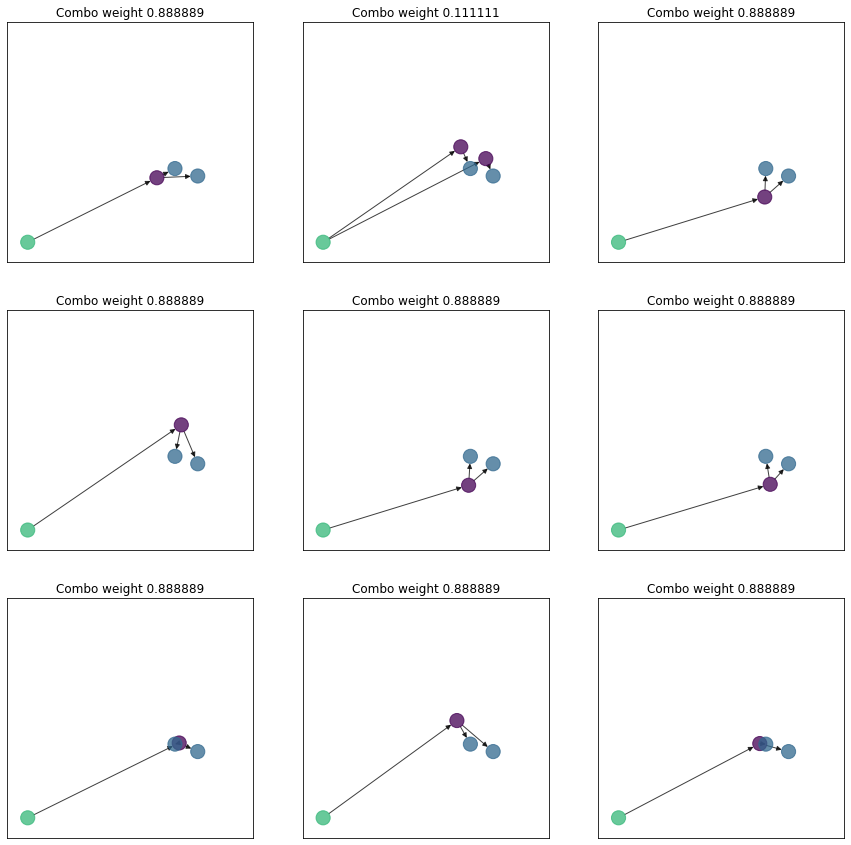

In [152]:
# Sample trees from the results:
def sample_tree_from_results(inference_results):
    # Pick which tree structure
    weights = inference_results.categorical_weights
    combo_k = np.random.choice(len(weights),p=weights)
    
    # Grab that supertree from optimization
    optim_result = inference_results.optim_result
    super_tree = inference_results.all_super_trees[combo_k]
    assert optim_result.GetSolution(super_tree.feasibility_indicator)
    observed_nodes = inference_results.all_observed_nodes[combo_k]
    observed_node_types = inference_results.observed_node_types

    # Sanity-check observed nodes are explained properly.
    for observed_node in observed_nodes:
        if not np.isclose(np.sum(optim_result.GetSolution(observed_node.source_actives)), 1.):
            print("WARN: observed node at %s not explained by MLE sol." % observed_node.x)

    sampled_tree = nx.DiGraph()
    super_tree = deepcopy(super_tree)
    for node in super_tree:
        if node.active:
            sampled_tree.add_node(node)
            # Sample node xy
            if node.type in observed_node_types:
                # Node xy distribution is delta -> copy it over
                node.x = optim_result.GetSolution(node.x_optim)
            else:
                # Node xy distribution is Uniform -> sample
                lb = optim_result.GetSolution(node.x_optim_lb)
                ub = optim_result.GetSolution(node.x_optim_ub)
                node.x = np.random.uniform(lb, ub)
            parents = list(super_tree.predecessors(node))
            assert len(parents) <= 1
            if len(parents) == 1:
                parent = parents[0]
                assert parent.active
                sampled_tree.add_edge(parent, node)
    return sampled_tree, weights[combo_k]

width = 3
height = 3
plt.figure().set_size_inches(5*width, 5*height)
for k in range(width*height):
    plt.subplot(width, height, k+1)
    sampled_tree, weight = sample_tree_from_results(inference_results)
    draw_tree(sampled_tree, alpha=0.75, ax=plt.gca())
    plt.title("Combo weight %f" % weight)

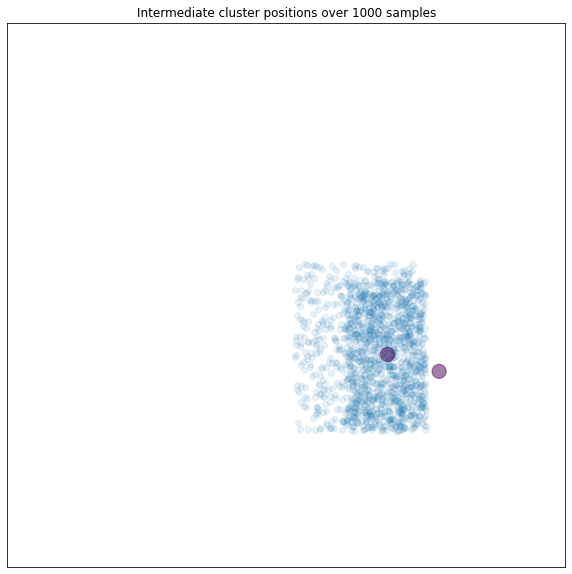

In [145]:
# Plot intermediate node density as a heatmap, overlaid on
from scipy.stats.kde import gaussian_kde

def draw_intermediate_node_heatmaps(inference_results, n_samples=1000):
    grammar = inference_results.grammar
    observed_node_types = inference_results.observed_node_types
    non_root_non_observed_types = [type for type in grammar.keys() if type not in observed_node_types and type is not "root"]
    # Sample a bunch of trees
    trees = [sample_tree_from_results(inference_results) for k in range(n_samples)]
    # Pick out nodes of each type
    by_type = {type: [] for type in non_root_non_observed_types}
    for tree, weight in trees:
        for type in by_type.keys():
            by_type[type] += [(n, weight) for n in tree.nodes if n.type == type]
    plt.figure().set_size_inches(10, 10)
    for k, type in enumerate(by_type.keys()):
        ax = plt.subplot(1, len(non_root_non_observed_types), k+1)
        x = [n.x[0] for n, _ in by_type[type]]
        y = [n.x[1] for n, _ in by_type[type]]
        weights = [w for _, w in by_type[type]]
        
        #k = gaussian_kde(np.vstack([x, y]), weights=weights)
        #xi, yi = np.mgrid[0:1:0.01,0:1:0.01]
        #zi = k(np.vstack([xi.flatten(), yi.flatten()]))
        #plt.gca().pcolormesh(xi, yi, zi.reshape(xi.shape), alpha=0.75, cmap=plt.get_cmap("GnBu"))
        #plt.gca().contourf(xi, yi, zi.reshape(xi.shape), alpha=1.0, cmap=plt.get_cmap("GnBu"))
        plt.scatter(x, y, alpha=0.1)

        draw_observed_nodes(inference_results.base_observed_nodes)
        plt.title("Intermediate %s positions over %d samples" % (type, n_samples))
        plt.gca().add_patch(Rectangle([0, 0], 1, 1, facecolor='none'))
draw_intermediate_node_heatmaps(inference_results, n_samples=1000)

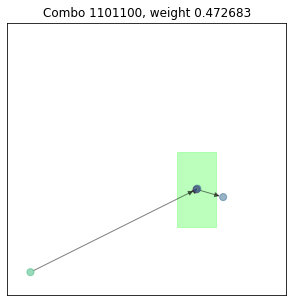

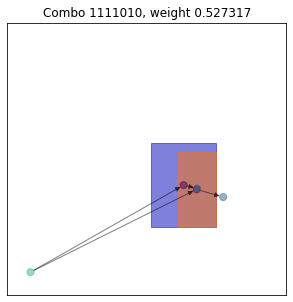

In [147]:
# Draw all ways of explaining the given scene, with support boxes for each node type.
# Sample trees from the results:
from matplotlib.patches import Rectangle
def draw_all_explanations(inference_results, width=5, draw_as_supertree=False):
    nonzero_weights_and_combos = [(k, w) for k, w in enumerate(inference_results.categorical_weights) if w > 1E-4]
    #height = len(nonzero_weights_and_combos) // 5 + 1
    for k, (combo_k, weight) in enumerate(nonzero_weights_and_combos):
        plt.figure().set_size_inches(5, 5)
        
        # Grab that supertree from optimization
        optim_result = inference_results.optim_result
        super_tree = inference_results.all_super_trees[combo_k]
        assert optim_result.GetSolution(super_tree.feasibility_indicator)
        observed_nodes = inference_results.all_observed_nodes[combo_k]
        observed_node_types = inference_results.observed_node_types

        # Sanity-check observed nodes are explained properly.
        for observed_node in observed_nodes:
            if not np.isclose(np.sum(optim_result.GetSolution(observed_node.source_actives)), 1.):
                print("WARN: observed node at %s not explained by MLE sol." % observed_node.x)

        illustration_tree = nx.DiGraph()
        colors_by_type = {}
        node_colors = {}
        for node in super_tree:
            if node.active:
                illustration_tree.add_node(node)
                color = plt.get_cmap("jet")(np.random.random())
                node_colors[node] = color
                # Put node xy at center of support region
                # and draw support regions
                if node.type in observed_node_types:
                    # Node xy distribution is delta -> copy it over
                    node.x = optim_result.GetSolution(node.x_optim)
                else:
                    # Node xy distribution is Uniform -> sample
                    lb = optim_result.GetSolution(node.x_optim_lb)
                    ub = optim_result.GetSolution(node.x_optim_ub)
                    node.x = (lb + ub) / 2.
                    if not draw_as_supertree:
                        plt.gca().add_patch(
                            Rectangle(lb, ub[0]-lb[0], ub[1]-lb[1],
                                     color=color,
                                     alpha=0.5))
                parents = list(super_tree.predecessors(node))
                assert len(parents) <= 1
                if len(parents) == 1:
                    parent = parents[0]
                    assert parent.active
                    illustration_tree.add_edge(parent, node)
        # Draw
        if draw_as_supertree:
            draw_tree(illustration_tree, alpha=0.9, ax=plt.gca(), draw_pos=False)
            plt.gca().set_xlim(-2, 2)
            plt.gca().set_ylim(-2, 2)
        else:
            draw_tree(illustration_tree, alpha=0.5, ax=plt.gca(), node_size=50)
        binary_string = format(combo_k, '#0%db' % (len(super_tree.nodes)+2))[2:]
        plt.title("Combo %0s, weight %f" % (binary_string, weight))

draw_all_explanations(inference_results, draw_as_supertree=False)

# Population-driven parameter optimization

Now more standard / full problem: given a dataset of observed scenes $O = {o_i}$ + a parameterized grammar description,  optimize the grammar params to fit the data.

$$ \arg\max_\theta \log p_\theta(O) = \log \int_T p_\theta(O | T) p_\theta(T) dT$$

We can think more specifically about those terms:
- $p(O | T)$ describes the likelihood a given tree can produce this dataset.
- $p_\theta(T)$ is the likelihood of the tree.


Consider $p(x) = \{x=0: A, x=1: B, x=2: C\}$, and $q_\theta(x)$ tries to copy it with three categorical weights $\theta_i$ that sum to 1.
$$
min_\theta D_{KL}(p(x) || q_\theta(x))\\
= min_\theta \sum_{x} p(x) \log \dfrac{p(x)}{q_\theta(x)}\\
= \min_\theta \left[A*\log\dfrac{A}{\theta_1} + B\log\dfrac{B}{\theta_2} + C*\log\dfrac{C}{\theta_3}\right]\\
= \min_\theta \left[\log{A^A * B^B * C^C} - A\log{\theta_1} - B \log \theta_2 - C \log \theta_3 \right]
$$
Such that thetas sum to 1.
By Wolfram Alpha, the sol has $\theta = [A, B, C]$, which recovers $x$, which is good. The log is the reason the optimal sol isn't to dump all of $\theta$ into one of the terms -- doing so sees diminishing returns due to the falloff of log, so it's better to mix the different logs.